

This notebook analyzes data from the drawing + eye tracking tool.  
It requires the exported JSON (strokes + gaze) and trial PNGs as input for now


In [17]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from PIL import Image
from pathlib import Path
from scipy.ndimage import gaussian_filter

%matplotlib inline
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.facecolor'] = 'white'

In [18]:
# === EDIT THIS PATH ===
DATA_DIR = Path("./")  

# Load JSON
with open(DATA_DIR / "data.json") as f:
    session = json.load(f)

# Load trial PNGs
trial_images = {}
for i in range(1, len(session['trials']) + 1):
    img_path = DATA_DIR / f"trial{i}.png"
    if img_path.exists():
        trial_images[i] = Image.open(img_path)

print(f"Participant: {session['participantId']}")
print(f"Screen: {session['screenWidth']}×{session['screenHeight']}")
print(f"Canvas: {session['canvasWidth']}×{session['canvasHeight']}")
print(f"Device pixel ratio: {session['devicePixelRatio']}")
print(f"Trials: {len(session['trials'])}")
print(f"Trial images loaded: {list(trial_images.keys())}")

Participant: M
Screen: 1210×727
Canvas: 1210×599
Device pixel ratio: 2
Trials: 3
Trial images loaded: [1, 2, 3]


In [19]:
def parse_trial(trial):
    """
    Convert one trial's data into stroke and gaze DataFrames.
    All times are in ms since session start.
    """
    tn = trial['trialNumber']

    # --- Strokes ---
    stroke_rows = []
    for stroke in trial['strokes']:
        for pt in stroke['points']:
            stroke_rows.append({
                'trial': tn,
                'stroke_id': stroke['strokeId'],
                'tool': stroke['tool'],
                'color': stroke['color'],
                'thickness': stroke['thickness'],
                'x': pt['x'],
                'y': pt['y'],
                'pressure': pt['pressure'],
                'time': pt['time']
            })
    strokes_df = pd.DataFrame(stroke_rows)

    # --- Gaze ---
    gaze_df = pd.DataFrame(trial['gazeData'])
    if not gaze_df.empty:
        gaze_df['trial'] = tn

    # --- Actions ---
    actions_df = pd.DataFrame(trial.get('actions', []))
    if not actions_df.empty:
        actions_df['trial'] = tn

    return strokes_df, gaze_df, actions_df


# Parsing all trials
all_strokes, all_gaze, all_actions = [], [], []
for trial in session['trials']:
    s, g, a = parse_trial(trial)
    all_strokes.append(s)
    all_gaze.append(g)
    all_actions.append(a)

strokes_df = pd.concat(all_strokes, ignore_index=True)
gaze_df = pd.concat(all_gaze, ignore_index=True)
actions_df = pd.concat(all_actions, ignore_index=True)

print(f"Total stroke points: {len(strokes_df):,}")
print(f"Total gaze points:   {len(gaze_df):,}")
print(f"Total actions:       {len(actions_df)}")
print()
print("Strokes sample:")
strokes_df.head()

Total stroke points: 3,474
Total gaze points:   6,256
Total actions:       0

Strokes sample:


,trial,stroke_id,tool,color,thickness,x,y,pressure,time
0,1,0,pen,#2a9d8f,4,410,218,0.080,46389.0
1,1,0,pen,#2a9d8f,4,410,219,0.030,46421.0
2,1,0,pen,#2a9d8f,4,410,219,0.030,46421.0
3,1,0,pen,#2a9d8f,4,411,219,0.008,46438.0
4,1,0,pen,#2a9d8f,4,411,219,0.008,46438.0


In [20]:
print("Gaze sample:")
gaze_df.head()

Gaze sample:


,x,y,time,trial
0,959.7,667.9,36550.0,1
1,957.4,661.1,36571.0,1
2,957.2,678.0,36579.0,1
3,956.1,667.8,36596.0,1
4,967.4,669.8,36612.0,1


### Drawing + Gaze Overlay

Shows us the final drawing PNG with gaze points overlaid.  
Gaze is in **screen coordinates**, so we need to offset by the canvas position on screen.  
The topbar and toolbar take up vertical space — adjust `CANVAS_OFFSET_Y` if needed (WIP)

In [21]:
# These offsets map screen-pixel gaze coords to canvas-pixel coords.
# The canvas sits below a topbar (48px) and above a toolbar (80px).
# Adjust if your layout is different.
CANVAS_OFFSET_X = 0
CANVAS_OFFSET_Y = 48   # topbar height from CSS
CANVAS_W = session['canvasWidth']
CANVAS_H = session['canvasHeight']


def gaze_to_canvas(gaze_trial_df):
    """
    Convert screen-space gaze coordinates to canvas-space.
    Returns a copy with adjusted x, y columns.
    """
    df = gaze_trial_df.copy()
    df['cx'] = df['x'] - CANVAS_OFFSET_X
    df['cy'] = df['y'] - CANVAS_OFFSET_Y
    # Clip to canvas bounds
    df = df[(df['cx'] >= 0) & (df['cx'] <= CANVAS_W) &
            (df['cy'] >= 0) & (df['cy'] <= CANVAS_H)]
    return df

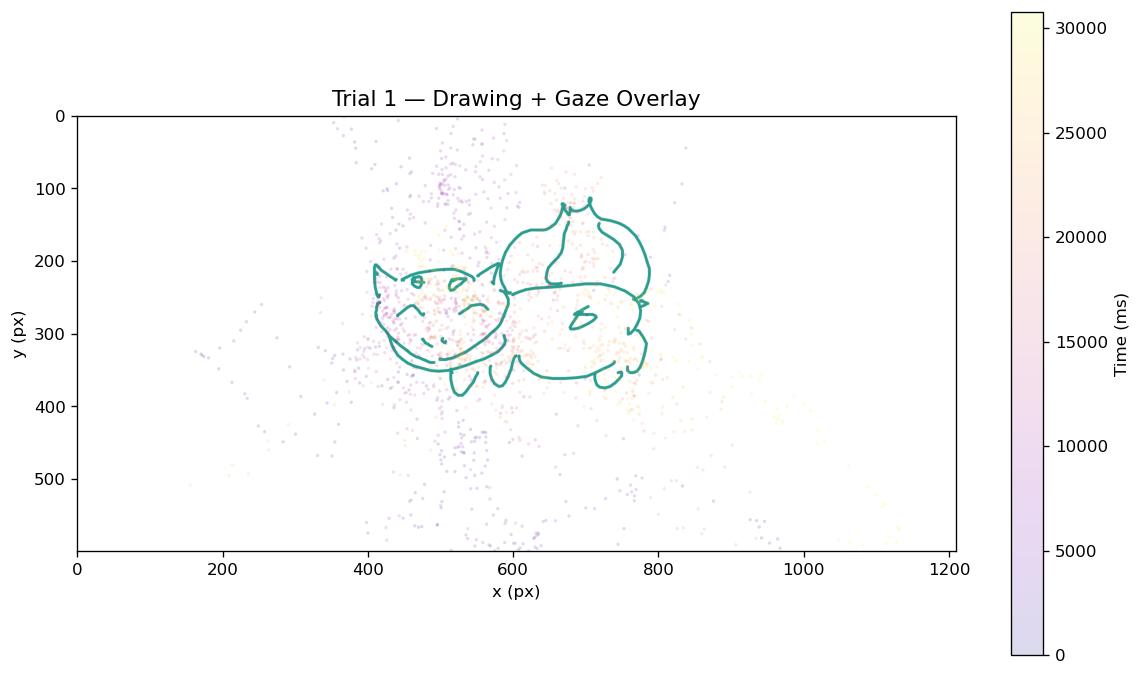

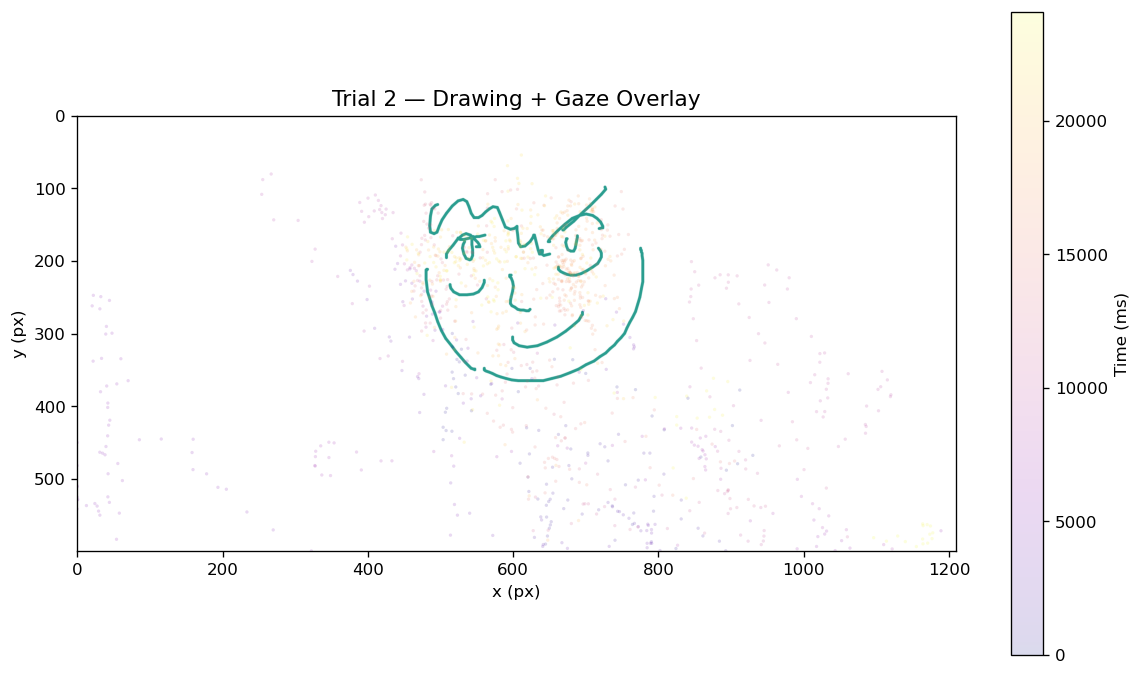

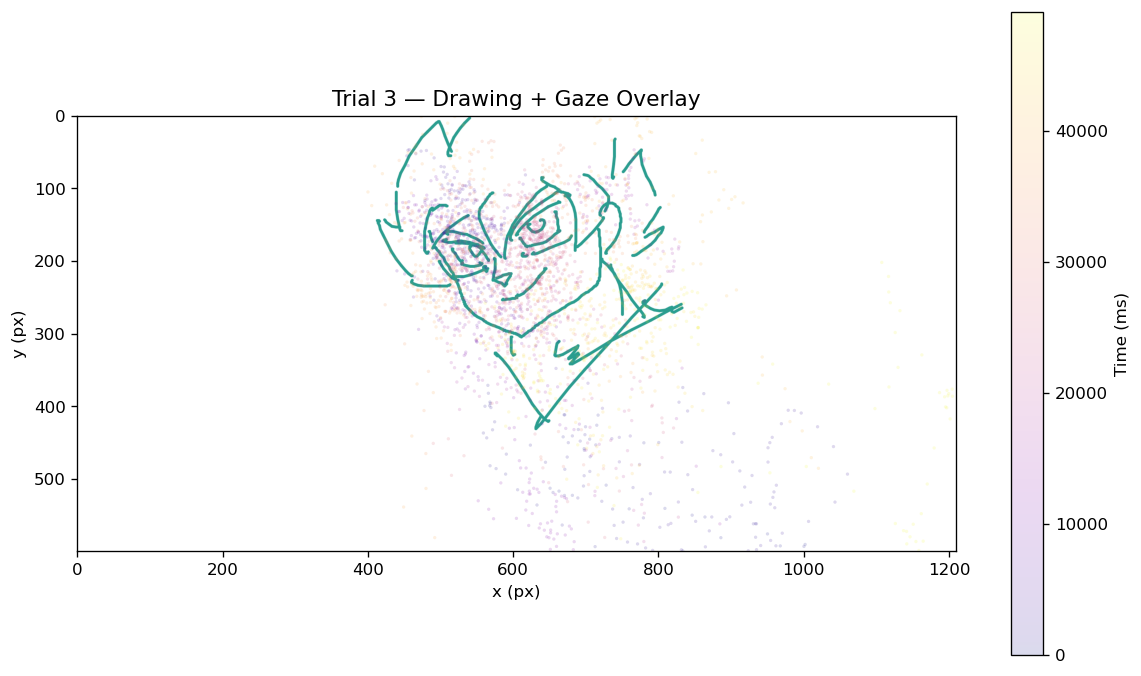

In [22]:
def plot_drawing_with_gaze(trial_num, alpha=0.15, gaze_size=4):
    """
    Plot a trial's final drawing with gaze points overlaid.
    """
    trial = session['trials'][trial_num - 1]
    gaze_t = gaze_df[gaze_df['trial'] == trial_num]
    gaze_c = gaze_to_canvas(gaze_t)

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    # Show the drawing PNG as background
    if trial_num in trial_images:
        ax.imshow(trial_images[trial_num], extent=[0, CANVAS_W, CANVAS_H, 0])
    else:
        ax.set_facecolor('white')

    # Overlay gaze, colored by time
    if not gaze_c.empty:
        t_rel = gaze_c['time'] - gaze_c['time'].iloc[0]  # relative time
        sc = ax.scatter(
            gaze_c['cx'], gaze_c['cy'],
            c=t_rel, cmap='plasma', s=gaze_size,
            alpha=alpha, edgecolors='none'
        )
        cbar = plt.colorbar(sc, ax=ax, label='Time (ms)', shrink=0.8)

    ax.set_xlim(0, CANVAS_W)
    ax.set_ylim(CANVAS_H, 0)
    ax.set_title(f'Trial {trial_num} — Drawing + Gaze Overlay', fontsize=13)
    ax.set_xlabel('x (px)')
    ax.set_ylabel('y (px)')
    plt.tight_layout()
    plt.show()


# Plot each trial
for t in range(1, len(session['trials']) + 1):
    plot_drawing_with_gaze(t)

### visualizing stroke trajectories

 Stroke width reflects pen pressure.

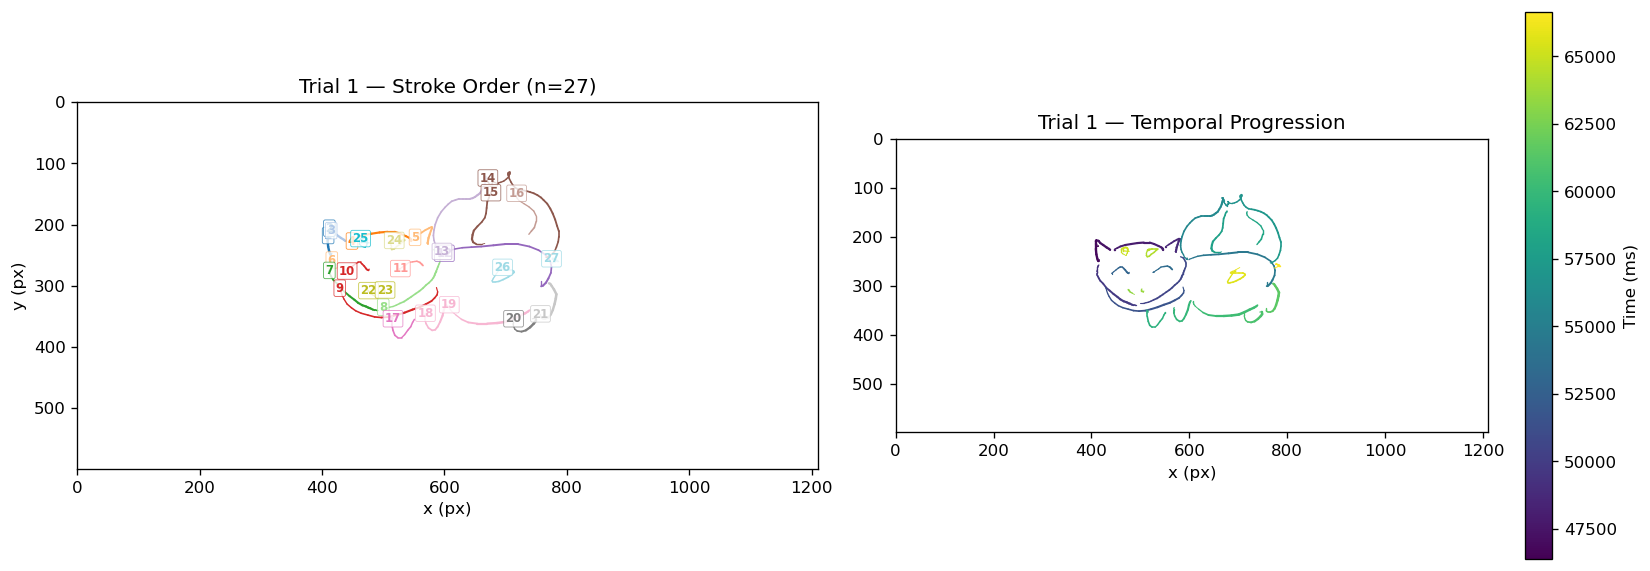

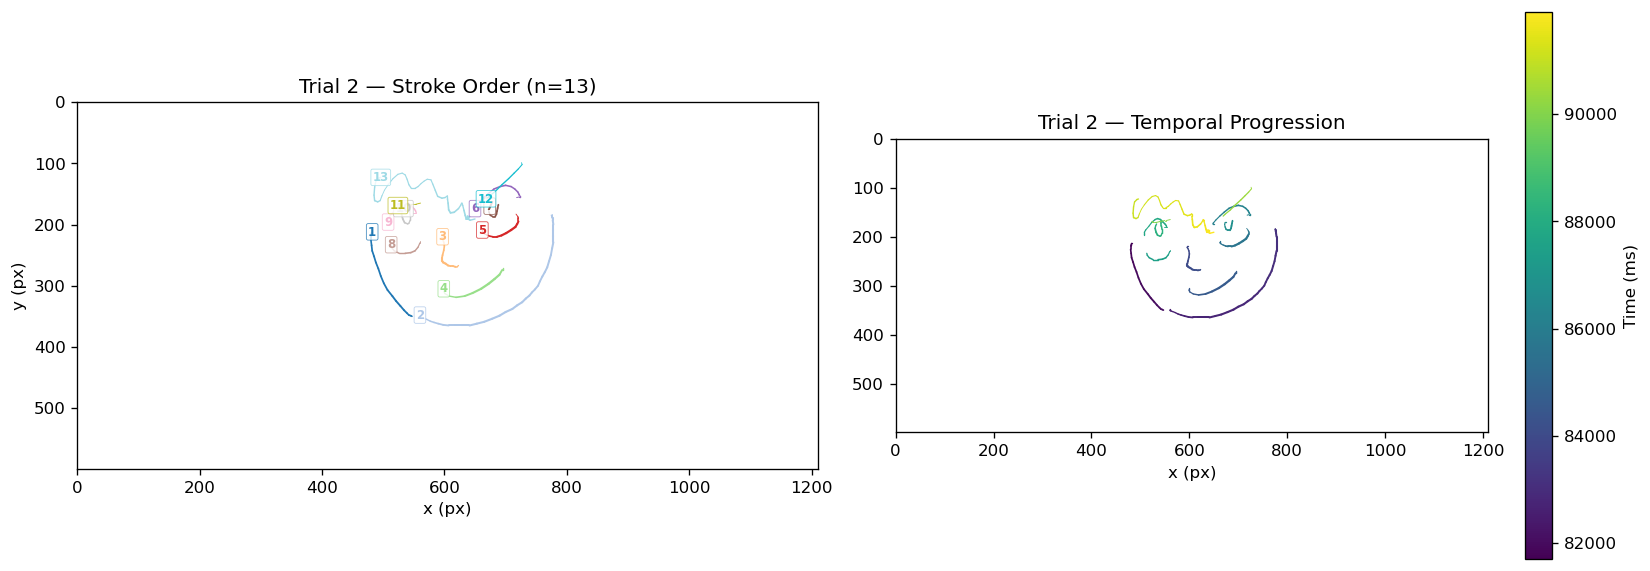

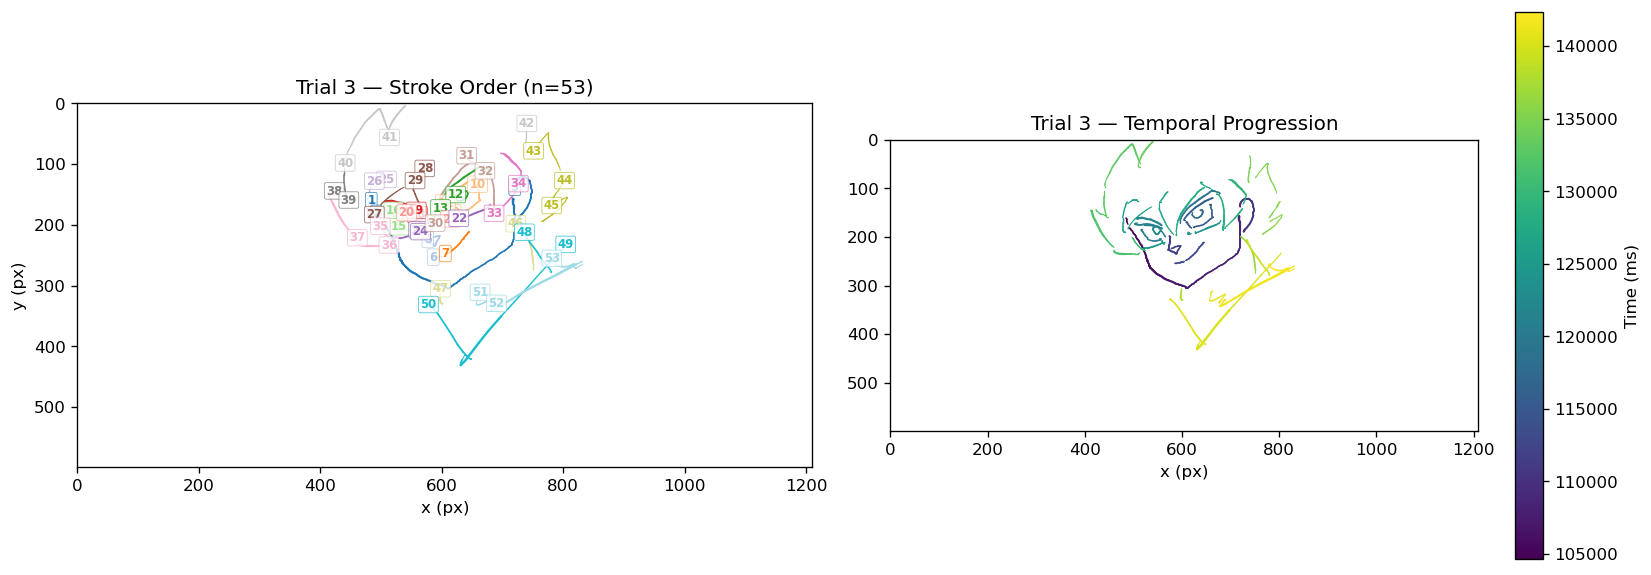

In [23]:
def plot_stroke_trajectories(trial_num):
    """
    Draw strokes colored by stroke order, with pressure-based width.
    """
    df = strokes_df[strokes_df['trial'] == trial_num]
    if df.empty:
        print(f"No strokes in trial {trial_num}")
        return

    stroke_ids = df['stroke_id'].unique()
    n_strokes = len(stroke_ids)
    cmap = plt.cm.get_cmap('tab20', max(n_strokes, 1))

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # --- Left: strokes colored by order ---
    ax = axes[0]
    for i, sid in enumerate(stroke_ids):
        s = df[df['stroke_id'] == sid]
        color = cmap(i / max(n_strokes - 1, 1))

        # Create line segments with pressure-based width
        points = np.array([s['x'].values, s['y'].values]).T.reshape(-1, 1, 2)
        if len(points) < 2:
            continue
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        widths = s['pressure'].values[:-1] * 4 + 0.5

        lc = LineCollection(segments, linewidths=widths, color=color, capstyle='round')
        ax.add_collection(lc)

        # Small numbered label at stroke start
        ax.annotate(str(i + 1), (s['x'].iloc[0], s['y'].iloc[0]),
                    fontsize=7, color=color, fontweight='bold',
                    ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.15', fc='white', ec=color, lw=0.5, alpha=0.8))

    ax.set_xlim(0, CANVAS_W)
    ax.set_ylim(CANVAS_H, 0)
    ax.set_aspect('equal')
    ax.set_title(f'Trial {trial_num} — Stroke Order (n={n_strokes})', fontsize=12)
    ax.set_xlabel('x (px)')
    ax.set_ylabel('y (px)')

    # --- Right: strokes colored by time ---
    ax2 = axes[1]
    t_min = df['time'].min()
    t_max = df['time'].max()
    norm = Normalize(vmin=t_min, vmax=t_max)

    for sid in stroke_ids:
        s = df[df['stroke_id'] == sid]
        points = np.array([s['x'].values, s['y'].values]).T.reshape(-1, 1, 2)
        if len(points) < 2:
            continue
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        colors = plt.cm.viridis(norm(s['time'].values[:-1]))
        widths = s['pressure'].values[:-1] * 4 + 0.5

        lc = LineCollection(segments, colors=colors, linewidths=widths, capstyle='round')
        ax2.add_collection(lc)

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    plt.colorbar(sm, ax=ax2, label='Time (ms)', shrink=0.8)
    ax2.set_xlim(0, CANVAS_W)
    ax2.set_ylim(CANVAS_H, 0)
    ax2.set_aspect('equal')
    ax2.set_title(f'Trial {trial_num} — Temporal Progression', fontsize=12)
    ax2.set_xlabel('x (px)')

    plt.tight_layout()
    plt.show()


for t in range(1, len(session['trials']) + 1):
    plot_stroke_trajectories(t)

### Claude assisted density heatmaps...

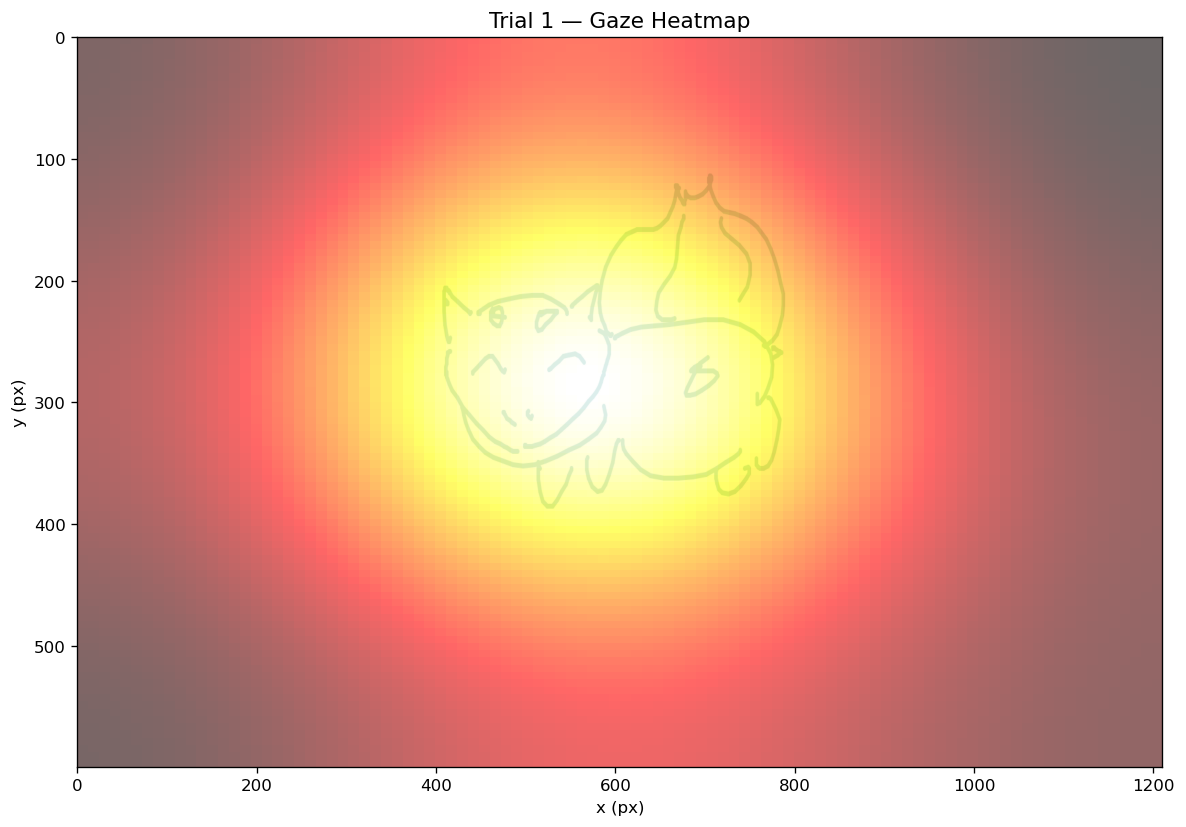

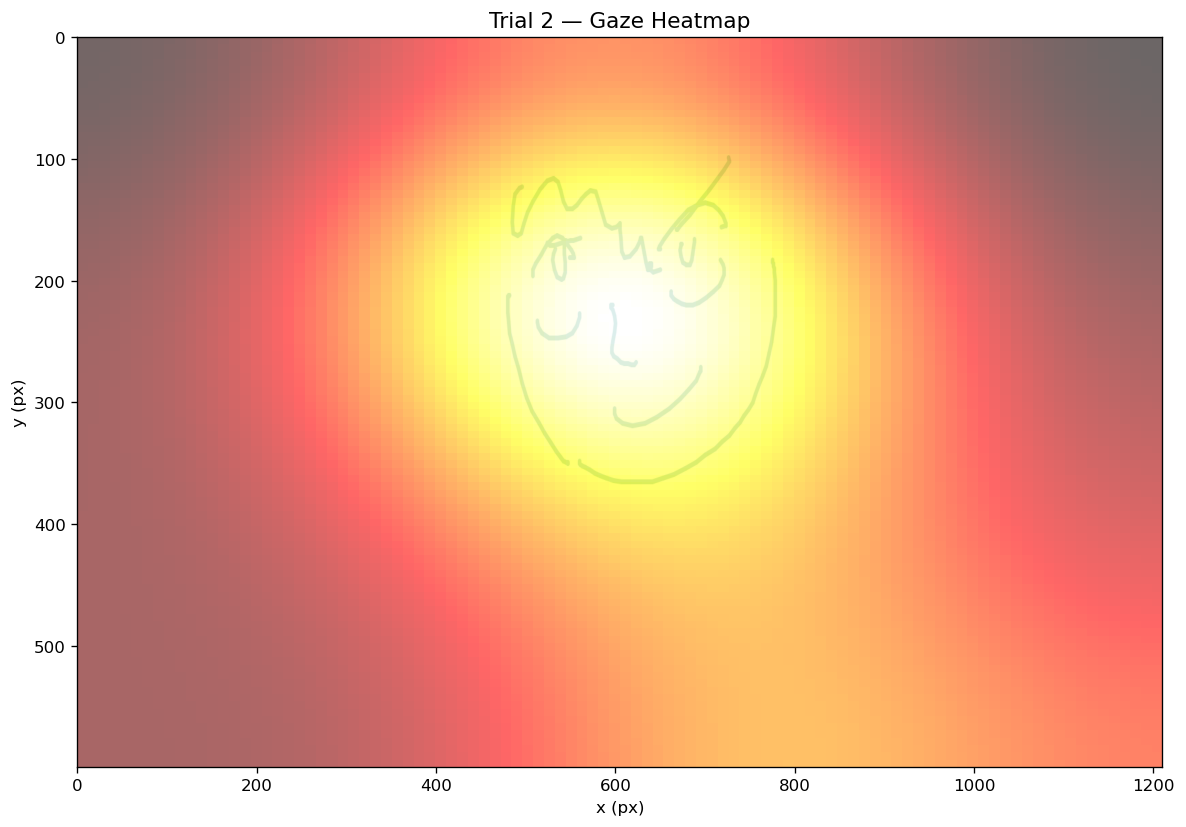

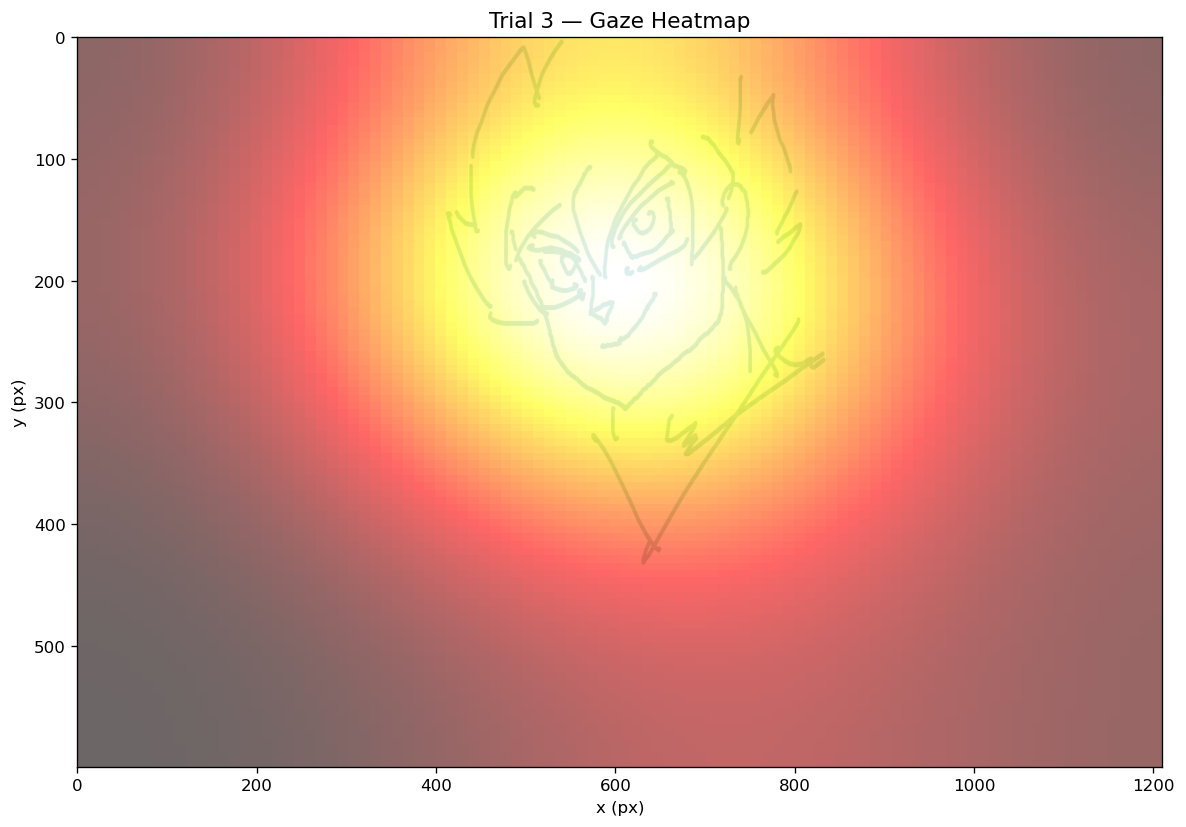

In [24]:
def plot_gaze_heatmap(trial_num, sigma=20, bins=100):
    """
    Gaussian-smoothed heatmap of gaze density over the canvas.
    """
    gaze_t = gaze_df[gaze_df['trial'] == trial_num]
    gaze_c = gaze_to_canvas(gaze_t)

    if gaze_c.empty:
        print(f"No gaze data for trial {trial_num}")
        return

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    # Show the drawing as a faded background
    if trial_num in trial_images:
        ax.imshow(trial_images[trial_num], extent=[0, CANVAS_W, CANVAS_H, 0], alpha=0.4)

    # Build 2D histogram and smooth it
    heatmap, xedges, yedges = np.histogram2d(
        gaze_c['cx'], gaze_c['cy'],
        bins=bins, range=[[0, CANVAS_W], [0, CANVAS_H]]
    )
    heatmap = gaussian_filter(heatmap.T, sigma=sigma)  # transpose so axes match

    ax.imshow(
        heatmap, extent=[0, CANVAS_W, CANVAS_H, 0],
        cmap='hot', alpha=0.6, aspect='auto'
    )

    ax.set_xlim(0, CANVAS_W)
    ax.set_ylim(CANVAS_H, 0)
    ax.set_title(f'Trial {trial_num} — Gaze Heatmap', fontsize=13)
    ax.set_xlabel('x (px)')
    ax.set_ylabel('y (px)')
    plt.tight_layout()
    plt.show()


for t in range(1, len(session['trials']) + 1):
    plot_gaze_heatmap(t)

## Trying to align strokes with points
For each stroke, we want to find the gaze points that occurred **during** that stroke.  

In [25]:
def align_gaze_to_strokes(trial_num):
    """
    For each stroke in a trial, extract gaze points that fell within
    [stroke_start_time, stroke_end_time].
    Returns a list of dicts with stroke + aligned gaze info.
    """
    trial = session['trials'][trial_num - 1]
    gaze_t = gaze_df[gaze_df['trial'] == trial_num]
    gaze_c = gaze_to_canvas(gaze_t)

    results = []
    for stroke in trial['strokes']:
        t_start = stroke['startTime']
        t_end = stroke['endTime']

        # Filter gaze to this stroke's time window
        mask = (gaze_c['time'] >= t_start) & (gaze_c['time'] <= t_end)
        gaze_during = gaze_c[mask]

        results.append({
            'stroke_id': stroke['strokeId'],
            'tool': stroke['tool'],
            'duration_ms': t_end - t_start,
            'n_stroke_points': len(stroke['points']),
            'n_gaze_points': len(gaze_during),
            'gaze_points': gaze_during
        })

    return results


# Show alignment summary for trial 1
alignment = align_gaze_to_strokes(1)
summary = pd.DataFrame([{
    'stroke_id': a['stroke_id'],
    'tool': a['tool'],
    'duration_ms': round(a['duration_ms'], 1),
    'stroke_pts': a['n_stroke_points'],
    'gaze_pts': a['n_gaze_points']
} for a in alignment])

print(f"Trial 1 — Gaze-Stroke Alignment ({len(alignment)} strokes):")
summary

Trial 1 — Gaze-Stroke Alignment (27 strokes):


,stroke_id,tool,duration_ms,stroke_pts,gaze_pts
0,0,pen,133.0,15,8
1,1,pen,285.0,29,17
2,2,pen,284.0,27,17
3,3,pen,317.0,38,14
4,4,pen,333.0,34,20
5,5,pen,151.0,19,9
6,6,pen,433.0,49,16
7,7,pen,650.0,76,39
8,8,pen,433.0,47,26
9,9,pen,234.0,26,14


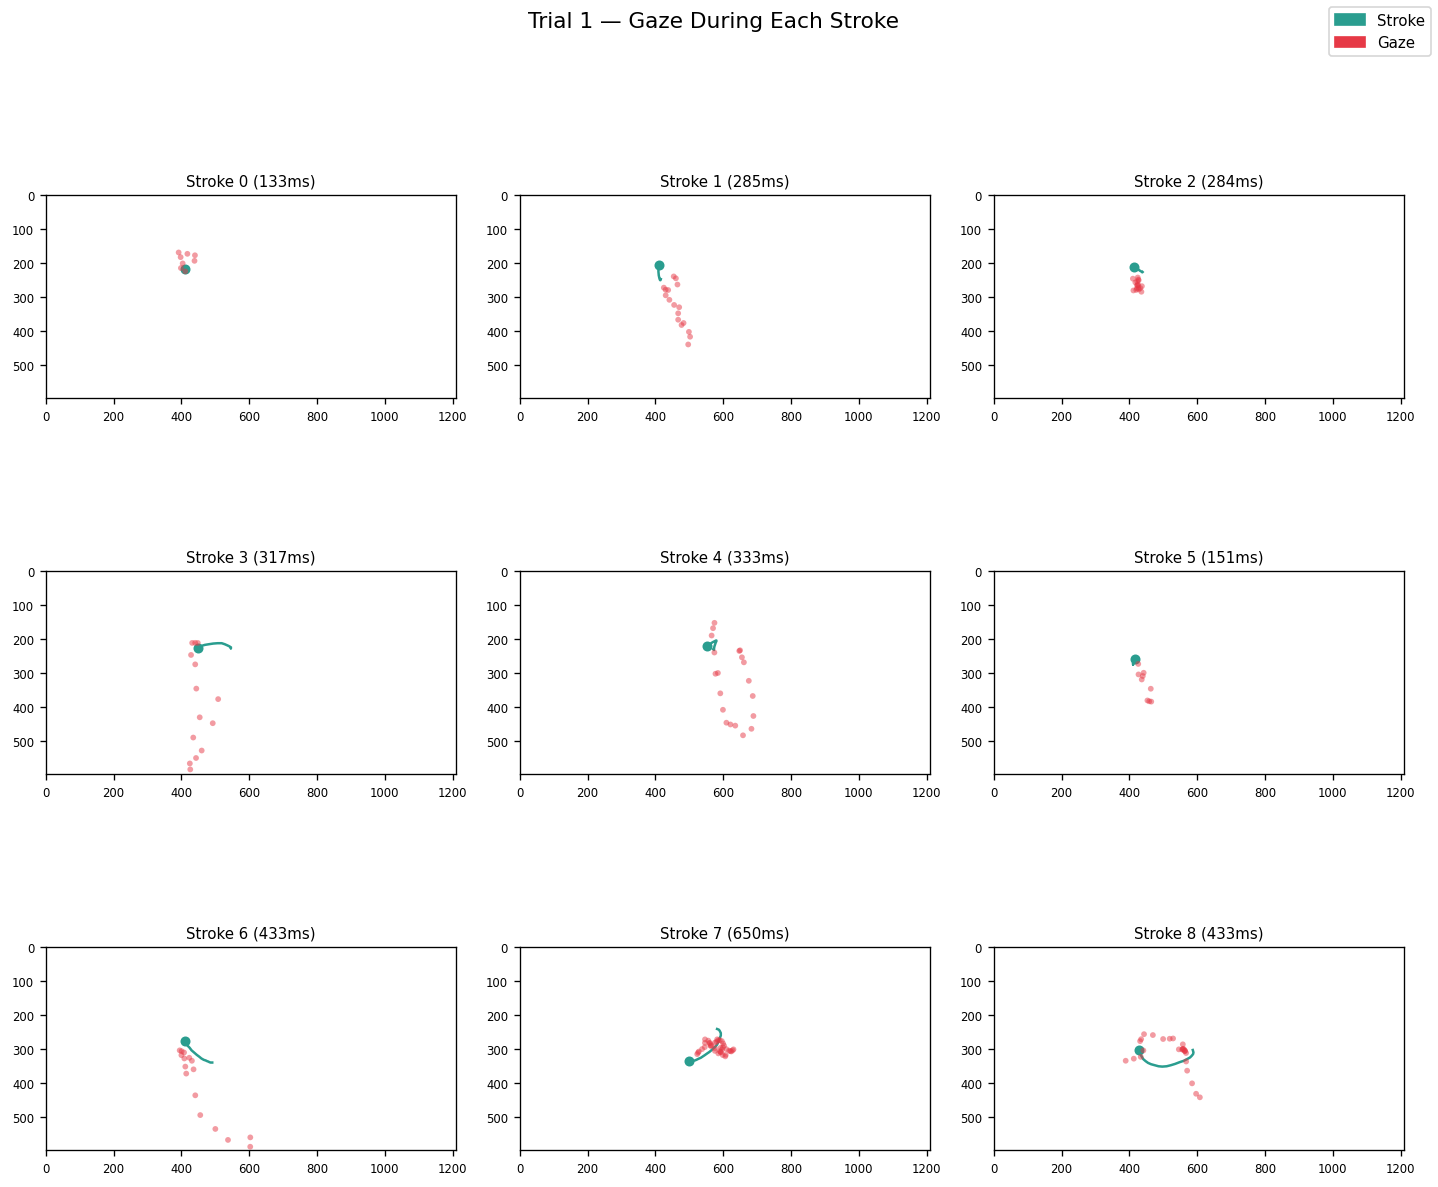

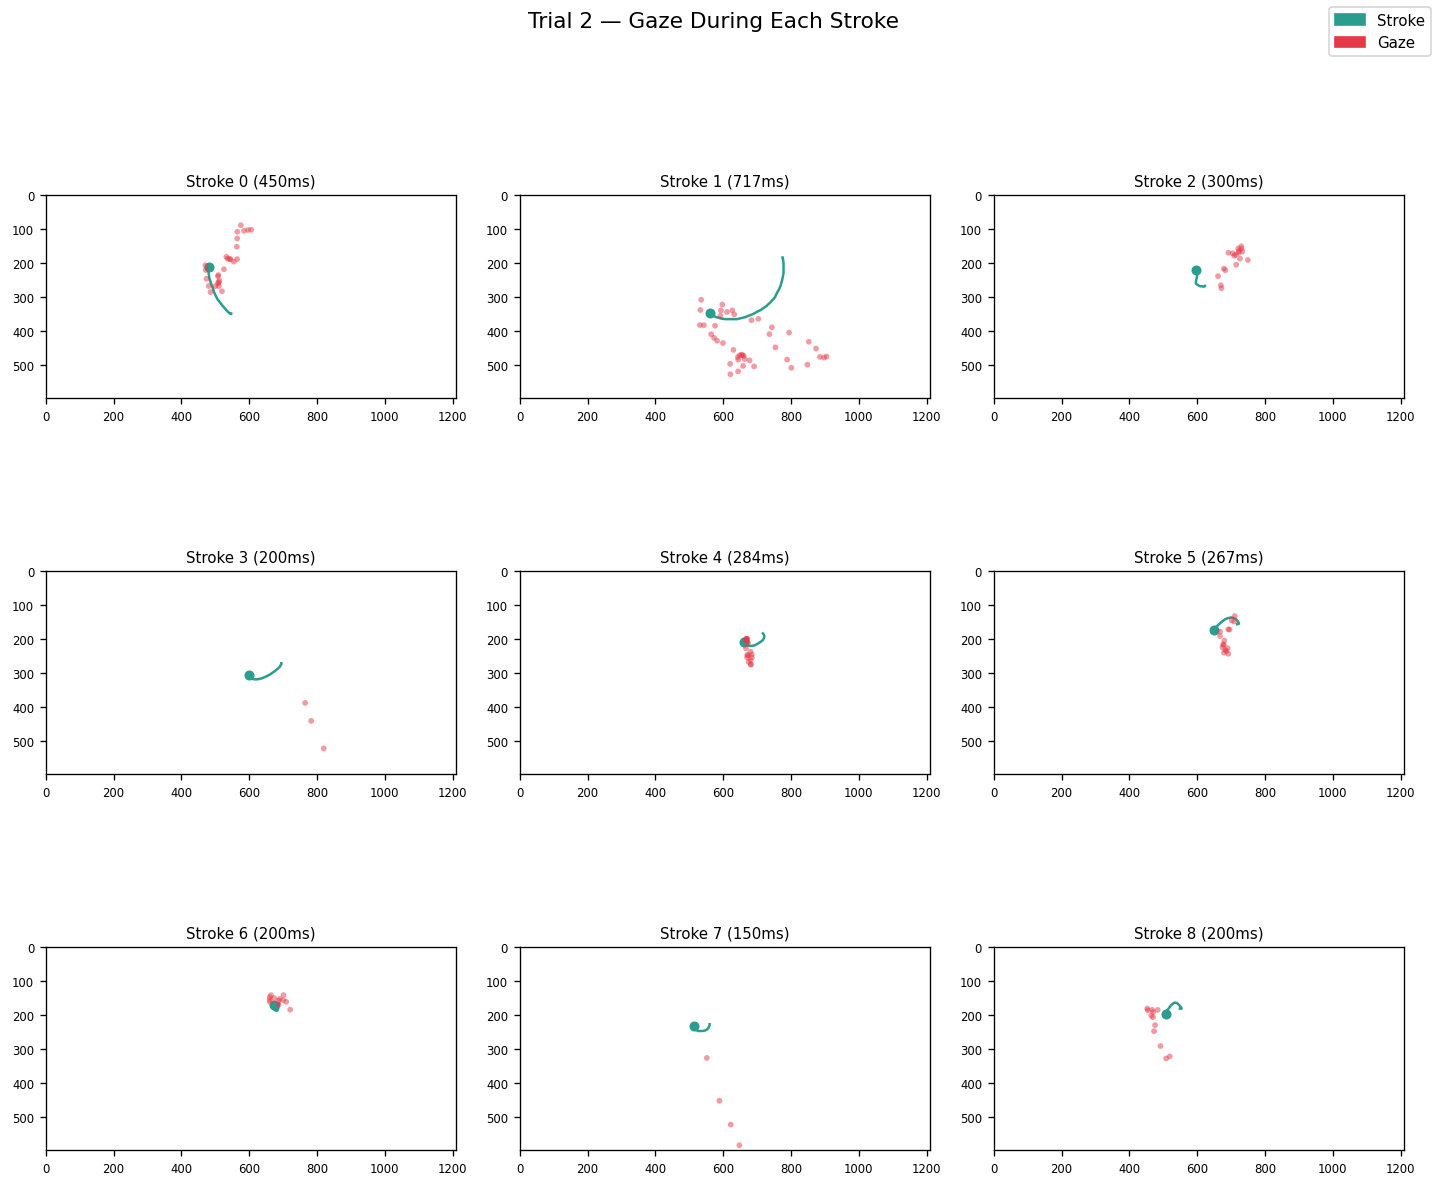

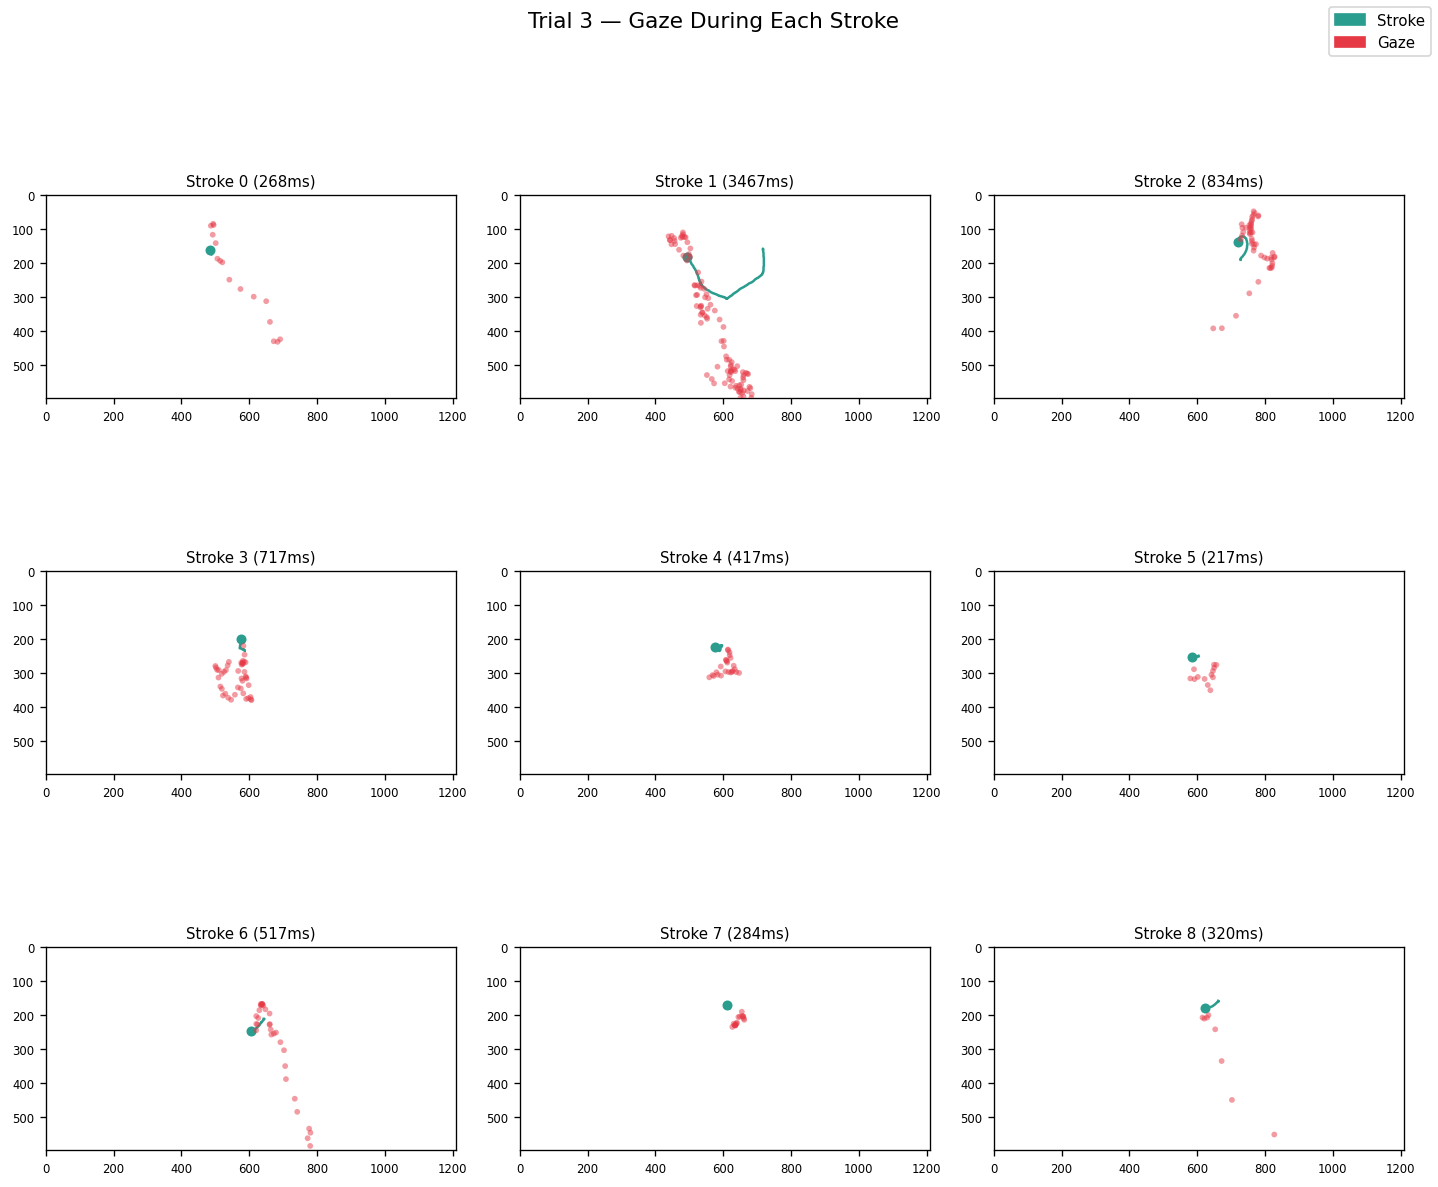

In [26]:
def plot_gaze_per_stroke(trial_num, max_strokes=9):
    """
    Small multiples: each panel shows one stroke (blue) with
    the simultaneous gaze positions (red).
    """
    alignment = align_gaze_to_strokes(trial_num)
    # Filter to pen strokes only (skip eraser)
    alignment = [a for a in alignment if a['tool'] == 'pen']
    n = min(len(alignment), max_strokes)
    if n == 0:
        print(f"No pen strokes in trial {trial_num}")
        return

    cols = min(n, 3)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3.5 * rows))
    if n == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    trial = session['trials'][trial_num - 1]

    for i in range(n):
        ax = axes[i]
        a = alignment[i]
        sid = a['stroke_id']

        # Get stroke points
        stroke_data = trial['strokes'][sid]
        sx = [p['x'] for p in stroke_data['points']]
        sy = [p['y'] for p in stroke_data['points']]

        # Plot stroke
        ax.plot(sx, sy, '-', color='#2a9d8f', linewidth=1.5, label='Stroke')
        ax.plot(sx[0], sy[0], 'o', color='#2a9d8f', markersize=5)  # start

        # Plot gaze during stroke
        gp = a['gaze_points']
        if not gp.empty:
            ax.scatter(gp['cx'], gp['cy'], c='#e63946', s=12, alpha=0.5,
                       edgecolors='none', label='Gaze', zorder=5)

        ax.set_xlim(0, CANVAS_W)
        ax.set_ylim(CANVAS_H, 0)
        ax.set_aspect('equal')
        ax.set_title(f'Stroke {sid} ({a["duration_ms"]:.0f}ms)', fontsize=9)
        ax.tick_params(labelsize=7)

    # Hide unused axes
    for j in range(n, len(axes)):
        axes[j].set_visible(False)

    # Shared legend
    handles = [
        mpatches.Patch(color='#2a9d8f', label='Stroke'),
        mpatches.Patch(color='#e63946', label='Gaze')
    ]
    fig.legend(handles=handles, loc='upper right', fontsize=9)
    fig.suptitle(f'Trial {trial_num} — Gaze During Each Stroke', fontsize=13, y=1.01)
    plt.tight_layout()
    plt.show()


for t in range(1, len(session['trials']) + 1):
    plot_gaze_per_stroke(t)

### summary stats that might be fun

In [27]:
summary_rows = []

for trial in session['trials']:
    tn = trial['trialNumber']
    duration_s = (trial['endTime'] - trial['startTime']) / 1000

    # Stroke stats
    st = strokes_df[strokes_df['trial'] == tn]
    pen_strokes = [s for s in trial['strokes'] if s['tool'] == 'pen']
    eraser_strokes = [s for s in trial['strokes'] if s['tool'] == 'eraser']

    # Gaze stats
    gt = gaze_df[gaze_df['trial'] == tn]
    gaze_rate = len(gt) / duration_s if duration_s > 0 else 0

    # Pressure stats (pen only)
    pen_pts = st[st['tool'] == 'pen']
    mean_pressure = pen_pts['pressure'].mean() if not pen_pts.empty else 0

    # Actions
    at = actions_df[actions_df['trial'] == tn] if not actions_df.empty else pd.DataFrame()
    n_undo = len(at[at['type'] == 'undo']) if not at.empty else 0
    n_clear = len(at[at['type'] == 'clear']) if not at.empty else 0

    summary_rows.append({
        'Trial': tn,
        'Duration (s)': round(duration_s, 1),
        'Pen strokes': len(pen_strokes),
        'Eraser strokes': len(eraser_strokes),
        'Total points': len(st),
        'Mean pressure': round(mean_pressure, 3),
        'Gaze samples': len(gt),
        'Gaze rate (Hz)': round(gaze_rate, 1),
        'Undos': n_undo,
        'Clears': n_clear
    })

summary_table = pd.DataFrame(summary_rows)
summary_table

,Trial,Duration (s),Pen strokes,Eraser strokes,Total points,Mean pressure,Gaze samples,Gaze rate (Hz),Undos,Clears
0,1,31.1,27,0,1026,0.113,1863,60.0,0,0
1,2,24.1,13,0,501,0.104,1446,60.0,0,0
2,3,49.1,53,0,1947,0.110,2947,60.0,0,0


### pressure over time!
If using Apple Pencil, pressure varies meaningfully. This shows pressure over time per trial.

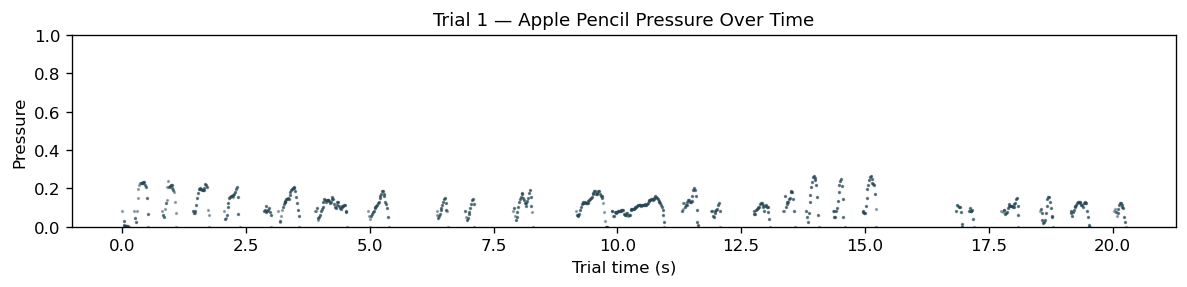

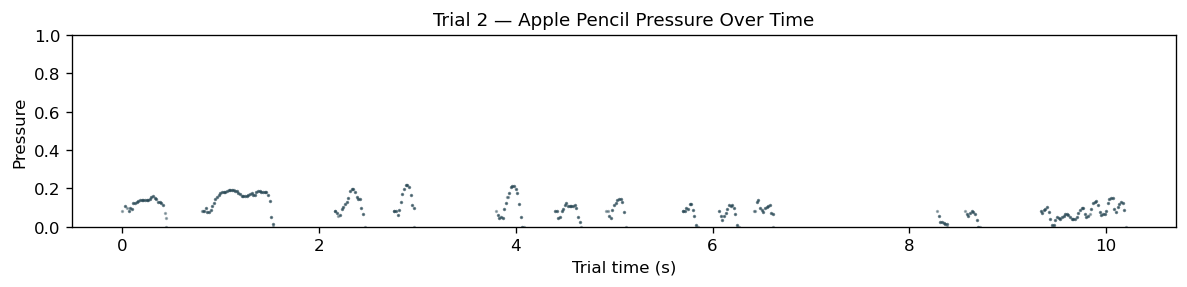

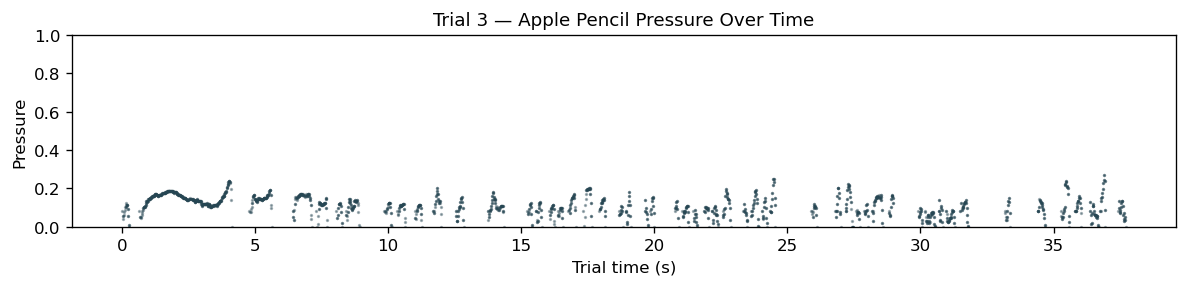

In [28]:
for trial in session['trials']:
    tn = trial['trialNumber']
    st = strokes_df[(strokes_df['trial'] == tn) & (strokes_df['tool'] == 'pen')]
    if st.empty:
        continue

    t_rel = (st['time'] - st['time'].min()) / 1000

    fig, ax = plt.subplots(figsize=(10, 2.5))
    ax.scatter(t_rel, st['pressure'], s=1, alpha=0.4, c='#264653')
    ax.set_xlabel('Trial time (s)')
    ax.set_ylabel('Pressure')
    ax.set_ylim(0, 1)
    ax.set_title(f'Trial {tn} — Apple Pencil Pressure Over Time', fontsize=11)
    plt.tight_layout()
    plt.show()